In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.formula.api import ols
from statsmodels.tsa.arima.model import ARIMA
from pmdarima import auto_arima

In [9]:
#importing the data

LAC_standardized_means = pd.read_csv('/Users/taylo/Downloads/envanalysis/group1-project/LAC_standardized_means.csv')


'Unnamed: 0'

In [25]:
#convert data so its ready to be usable in time series analysis

LAC_ready = LAC_standardized_means.rename(columns = {'Unnamed: 0' : 'Years', '0' : 'Standardized Mean'})

LAC_ready['Years'] = pd.to_datetime(LAC_standardized_means['Years'], format='%Y')

LAC_ready = LAC_ready.set_index('Years')


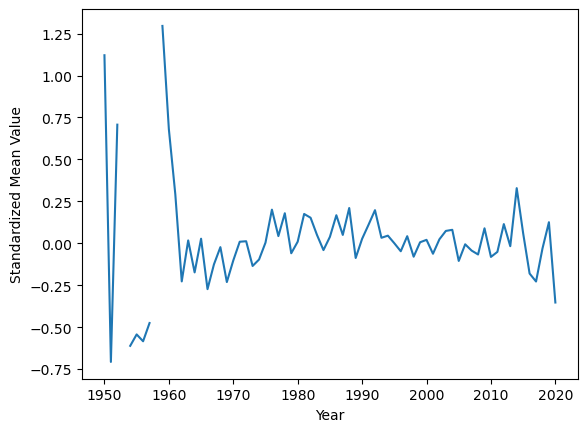

In [27]:
fig, ax = plt.subplots()
ax.plot(LAC_ready['Standardized Mean'])
ax.set_xlabel('Year')
ax.set_ylabel('Standardized Mean Value');

The standard mean value we are using for the time series analysis seems to be relatively constant, besides from the strange outliers in the early years

Autocorrelation and Stationarity do not allow NaN values, so for the following tests I made a new dataset where I deleted the years with NaN values (1953 and 1958)

In [40]:
LAC_noNaN = pd.read_csv('/Users/taylo/Downloads/envanalysis/group1-project/LAC_standardized_means_noNaN.csv')


LAC_noNaN = LAC_noNaN.rename(columns = {'Unnamed: 0' : 'Years', '0' : 'Standardized Mean'})

LAC_noNaN['Years'] = pd.to_datetime(LAC_noNaN['Years'], format='%Y')

LAC_noNaN = LAC_noNaN.set_index('Years')


,Standardized Mean
Years,
1950-01-01,1.120897
1951-01-01,-0.707107
1952-01-01,0.707107
1954-01-01,-0.611246
1955-01-01,-0.543236
...,...
2016-01-01,-0.180217
2017-01-01,-0.227834
2018-01-01,-0.030940


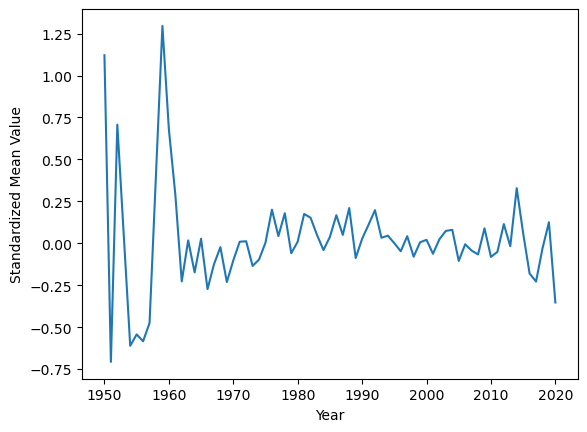

In [43]:
fig, ax = plt.subplots()
ax.plot(LAC_noNaN['Standardized Mean'])
ax.set_xlabel('Year')
ax.set_ylabel('Standardized Mean Value');

In [41]:
#investigating autocorrelation

from scipy.stats import pearsonr

lag = 1

# current year

LAC_t = LAC_noNaN['Standardized Mean'][:len(LAC_noNaN)-lag]

# one year/lag prior

LAC_t1 = LAC_noNaN['Standardized Mean'][lag:]

# calculate correlation
r, p = pearsonr(LAC_t, LAC_t1)
print('correlation:', r)
print('p-value:', p)

correlation: -0.04764287221277391
p-value: 0.6996384258888037


The p value from the autocorrelation function is large, which means There is not a significant correlation between a value of the standardized mean one year vs the following year.

In [42]:
def adf_print(time_series):
    adf_output = adfuller(time_series)
    stat = adf_output[0]
    pval = adf_output[1]
    print('ADF Statistic:', stat)
    print('p-value:', pval)
    return None

adf_print(LAC_noNaN)

ADF Statistic: -9.313065504062095
p-value: 1.0365053614466498e-15


The p value from the adf test is very small, which suggests that the standardized data is STATIONARY. The mean and variance do not change as time passes. There is no trend in the data.